## Part II of Technical Assessment

In [111]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV

In [2]:
data_path = "./dpi_datascience_practical/ds_practical.txt"
data = pd.read_csv(data_path, sep="|")

### Missing Values Exploration

One of the first things I am going to do is figure out how to interpret or deal with missing data or nan values in our dataframe. 

Understanding the pattern of missing values can actually be very important in how we move forward and represent these values in our dataset. These values could represent bugs, human error, incorrect readings, etc, and may add value to determining our predictions. Before we completely remove the rows containing missing data in our dataset, I want to explore them and 1) see if there are any hidden patterns that could tell us more information and 2) see how much of the dataset it makes up. 

One common method people often use is to convert nan or missing values to 0. For this problem, I believe it is not the best practice to do this as the value 0 has meaning in our dataset in each column. This method could more likely be used for a numerical dataset that has maybe only positive or only negative integers, or any dataset that does not use the value to 0 to represent something. 

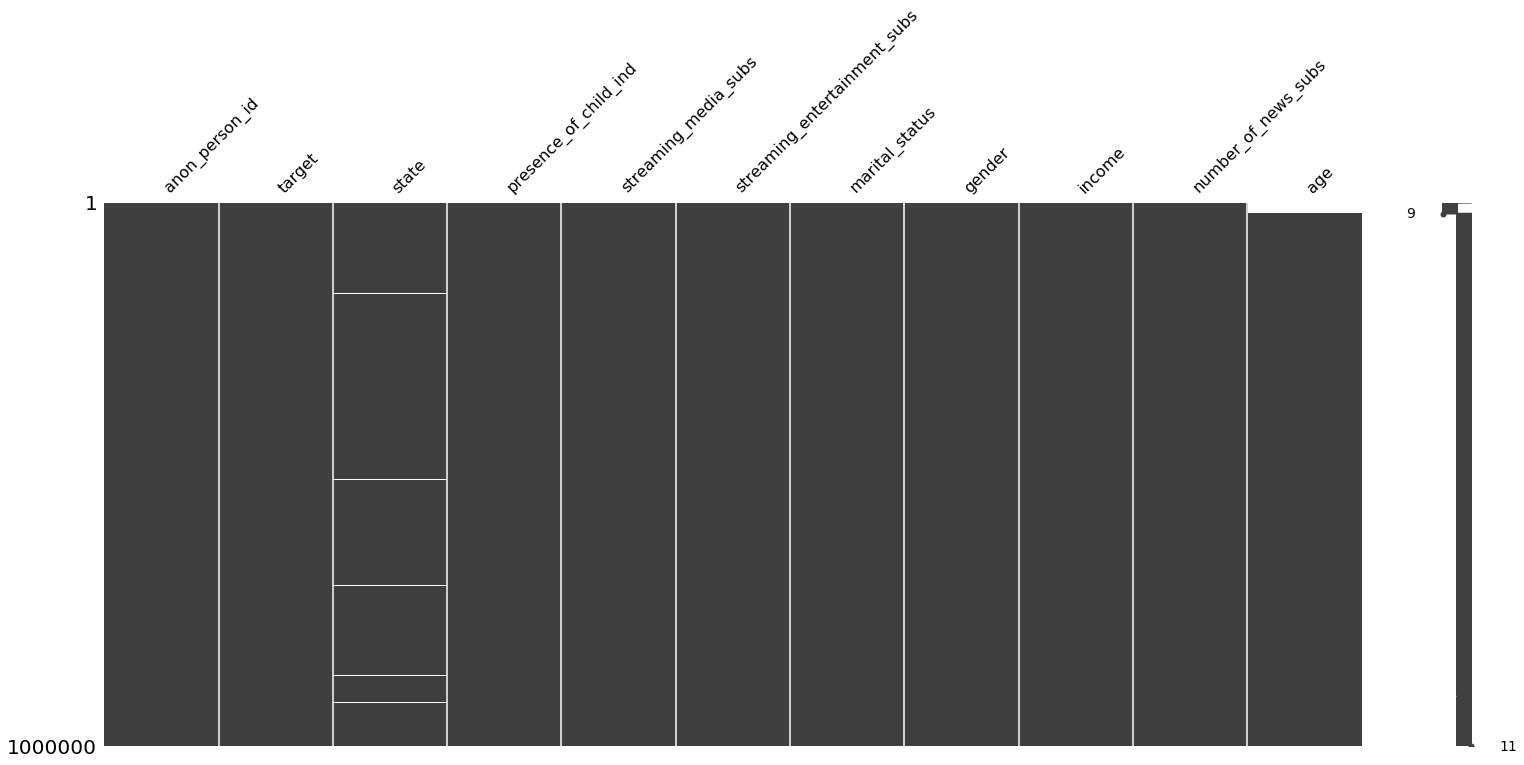

In [4]:
#visualize a matrix of where the missing data is dispersed in the dataset

msno.matrix(data)

In this visualization, the white represents missing data. From this, we can see that there is not a lot of missing data, just a few missing rows in the state and age column. It is probably going to be best to remove those few rows in this case, but I will check how much of the data it makes up to confirm my postulations. 

In [5]:
#get percentage of missing data
no_nan = data.dropna()
percent_missing = (len(data)-len(no_nan)) / len(data)
print("Missing data only makes up " + str("%.2f" %(percent_missing * 100)) + "% of the overall data.")

Missing data only makes up 2.95% of the overall data.


As we can see from the statement above, all the nan/missing data only represent 3% of the overall data, so therefore, our new dataset will contain rows with the nan values dropped such that we will only have rows that values in each column and still be able to keep more than 97% of the dataset to work with.  

In [6]:
final_dataset = data.dropna() 

### Convert Categorical to Numerical Data

Our dataset currently contains a mix of numerical and categorical columns. In order to train our model on our dataset, we need to convert everything to numerical data. The way I'm approaching this is essentially changing it from categorical labels to numerical labels such that it can be inputted into our models. Another method is one hot encoding, but I believe for this case, converting to numerical labels would be the most appropriate, such that when we do get our final results after training the model, we can determine which columns were most influential in predicting the target variable.  

In [7]:
#state, streaming media subs, marital status, gender, income

state = {s:i for i, s in enumerate(final_dataset['state'].unique())}
s_m_s = {s:i for i, s in enumerate(final_dataset['streaming_media_subs'].unique())}
marital_status = {s:i for i, s in enumerate(final_dataset['marital_status'].unique())}
gender = {s:i for i, s in enumerate(final_dataset['gender'].unique())}
income = {s:i for i, s in enumerate(final_dataset['income'].unique())}

print(state)
print(s_m_s)
print(marital_status)
print(gender)
print(income)

{'CA': 0, 'GA': 1, 'DC': 2}
{'N': 0, 'Y': 1}
{'M': 0, 'U': 1, 'S': 2}
{'Female': 0, 'Male': 1, 'feMalee': 2}
{'$175k-199k': 0, '$225k-249k': 1, '$150k-174k': 2, '$125k-149k': 3, '$100k-124k': 4, '$200k-224k': 5, '$250k+': 6, 'U': 7, '$75k-99k': 8, '$50k-74k': 9, '$25k-49k': 10, '<$25k': 11}


In [118]:
#convert 'feMalee' to Female such that this column is categorical between male and female

genders = list(final_dataset['gender'])
for i in range(len(genders)):
    if genders[i] == "feMalee":
        genders[i] = "Female"
        
final_dataset['gender'] = genders
gender = {s:i for i, s in enumerate(final_dataset['gender'].unique())}

In [119]:
final_dataset['state'] = [state[i] for i in final_dataset['state']]
final_dataset['streaming_media_subs'] = [s_m_s[i] for i in final_dataset['streaming_media_subs']]
final_dataset['marital_status'] = [marital_status[i] for i in final_dataset['marital_status']]
final_dataset['gender'] = [gender[i] for i in final_dataset['gender']]
final_dataset['income'] = [income[i] for i in final_dataset['income']]

In [10]:
#visualize the finalized dataset 

final_dataset.head()

,anon_person_id,target,state,presence_of_child_ind,streaming_media_subs,streaming_entertainment_subs,marital_status,gender,income,number_of_news_subs,age
0,1,0,0,0,0,0,0,0,0,0,43.0
1,2,0,0,0,0,0,1,1,1,0,90.0
2,3,1,0,0,1,1,2,0,2,0,46.0
3,4,0,0,1,0,0,1,0,3,0,25.0
4,5,0,0,0,0,0,1,0,0,0,62.0


### Split into Train and Test Set 

In [87]:
X = final_dataset.drop(columns=['target'])
Y = final_dataset['target']

#split into x and y train/test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

### Resampling 

In [88]:
combined_train = pd.concat([x_train, y_train], axis=1)

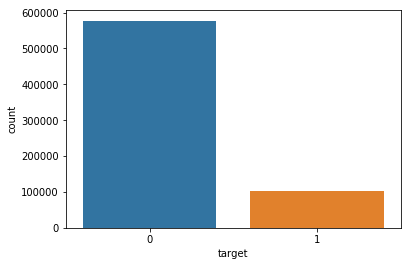

In [74]:
sns.countplot(combined_train['target'])

One thing to note here is that there is a highly uneven balance between users that do listen to the podcast (represented by 1) and users that do not listen to the podcast (represented by 0). It seems as though most of the users here do not listen to the podcast. 

If we don't do anything about the dataset and carry on with training the model on a dataset like this, it could lead to bias in the training model, leading to false high accuracies simply by predicting the majority class. We want our model to be robust and to actually predict based on the features it has taken as input. 

In order to fix this imbalance, we can resample the dataset: remove some samples from the majority class and add some samples to the minority class. Now, there are some constraints to doing this. If we remove samples from the majority class so that its length matches the minority class, we will be losing tons of data (basically majority of our data). There is a problem vice versa also, if we duplicate samples to add to our minority class, could potentially lead to overfitting because of duplicate data. A common way to get around this is to add minor variations to our data when adding more samples to the minority class. Since we do not have a way to apply this for now, I will be over-sampling with replacement from the minority class, and under-sampling from the majority class to create a middle balance. 

In [89]:
class_0 = combined_train[combined_train['target'] == 0]
class_1 = combined_train[combined_train['target'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)
print(len(class_0)/len(combined_train), len(class_1)/len(combined_train))

class 0: (577191, 11)
class 1: (102138, 11)
0.8496486974647042 0.15035130253529586


These calculations show that class 0 makes up 85% of the data, while class 1 only makes up 15% of the data. 

In [90]:
#Undersample from majority class - in this case, 0

#we are cutting down class 0 to half of its information
class_0 = class_0.sample(frac=0.5, random_state=1)
new_data = pd.concat([class_0, class_1])

#reassign X and Y 
X = new_data.drop(columns=['target'])
Y = new_data['target']

class_0 = new_data[new_data['target'] == 0]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)
print(len(class_0)/len(new_data), len(class_1)/len(new_data))

class 0: (288596, 11)
class 1: (102138, 11)
0.7385996611505525 0.26140033884944747


With undersampling, data is a little bit more balanced, but let's use oversampling to make it more balanced. 

In [91]:
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(X, Y)

y_ros = pd.DataFrame(y_ros, columns=['target'])
class_0 = y_ros[y_ros['target'] == 0]
class_1 = y_ros[y_ros['target'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)
print(len(class_0)/len(y_ros), len(class_1)/len(y_ros))

class 0: (288596, 1)
class 1: (288596, 1)
0.5 0.5


With a mix of oversampling and undersampling, we now have a balanced number of rows in each class, such that we can train our model with this data.

In [92]:
#reassign combined train to our new train dataset
combined_train = pd.concat([x_ros, y_ros], axis=1)
x_train = x_ros 
y_train = y_ros

### Data Exploration on Train Data

In [79]:
features = ['state', 'presence_of_child_ind', 'streaming_media_subs',
            'streaming_entertainment_subs', 'marital_status', 'gender','income',
            'number_of_news_subs', 'age', 'target']

Text(0, 0.5, 'Count')

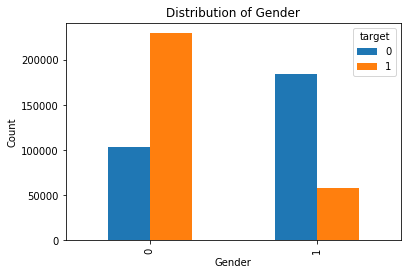

In [80]:
pd.crosstab(combined_train.gender, combined_train.target).plot(kind='bar')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

As a reminder from above, female is represented by 0, and male is represented by 1 for gender. This plot actually tells us quite a bit. The tendencies of male vs. female are quite opposite, as it seems the majority of females in the dataset do listen to the podcast, while majority of males in the dataset do not listen to the podcast. This might play a role in the model and be one of the more influential factors when predicting the target variable. 

Text(0, 0.5, 'Count')

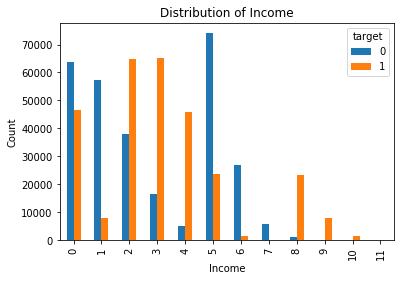

In [20]:
pd.crosstab(combined_train.income, combined_train.target).plot(kind='bar')
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Count')

In [21]:
income = {s:i for i, s in enumerate(data['income'].unique())}
print(income)

{'$175k-199k': 0, '$225k-249k': 1, '$150k-174k': 2, '$125k-149k': 3, '$100k-124k': 4, '$200k-224k': 5, '$250k+': 6, 'U': 7, '$75k-99k': 8, '$50k-74k': 9, '$25k-49k': 10, '<$25k': 11}


I added what the numbers for income refers to as a guide! From this distribution bar plot, we can see that majority of the podcast listeners earn an income between $100k-174k$, while those who don't listen to the podcast tend to make a little more ranging from $175k-250k$. While there is no direct explanation for why those who are making more money tend not to listen to the podcast, it is definitely something to consider and take into account the fact that there is some pattern/trend here. This could also be a influential factor in predicting the target variable. 

Text(0, 0.5, 'Count')

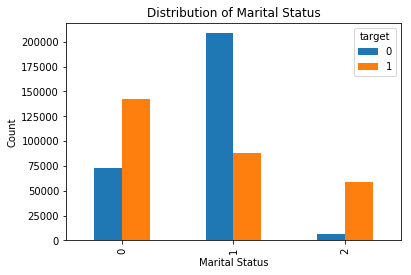

In [22]:
pd.crosstab(combined_train.marital_status, combined_train.target).plot(kind='bar')
plt.title('Distribution of Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')

In [23]:
marital_status = {s:i for i, s in enumerate(data['marital_status'].unique())}
print(marital_status)

{'M': 0, 'U': 1, 'S': 2}


I added what 0, 1, 2 for marital status here refers to as a guide! From this distribution bar plot, we can see that majority of the married listeners listen to the pocast. But, this plot does not tell us much because most of the marital labels are characterized into unknown.

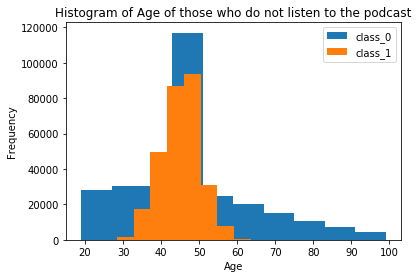

In [24]:
class_0 = combined_train[combined_train['target'] == 0]
class_1 = combined_train[combined_train['target'] == 1]
plt.hist(class_0.age)
plt.hist(class_1.age)
plt.title('Histogram of Age of those who do not listen to the podcast')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(['class_0', 'class_1'])

This plot tells us that most of the people in the dataset are between the age range of 40-50. Those who do listen to the podcast seem to have a smaller distribution of age, but overall, the distribution of age between both classes are around the same. This might not be a strong indicator in determining whether someone will listen to the podcast or not. 

Text(0, 0.5, 'Count')

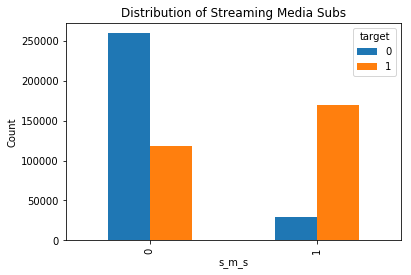

In [25]:
pd.crosstab(combined_train.streaming_media_subs, combined_train.target).plot(kind='bar')
plt.title('Distribution of Streaming Media Subs')
plt.xlabel('s_m_s')
plt.ylabel('Count')

In [26]:
s_m_s = {s:i for i, s in enumerate(data['streaming_media_subs'].unique())}
print(s_m_s)

{'N': 0, 'Y': 1}


This plot is pretty similar to the gener plot. The tendencies of those who do not stream media subs are opposite of those who do. Majority of those who stream media subs do not listen to the podcast, while the majority of those who do stream media subs, also listen to the podcast. This makes sense as those who interact more with media will probably be more inclined to listen to podcasts/use social media, etc. This may also be one of the more influential factors when predicting the target variable.

Text(0, 0.5, 'Count')

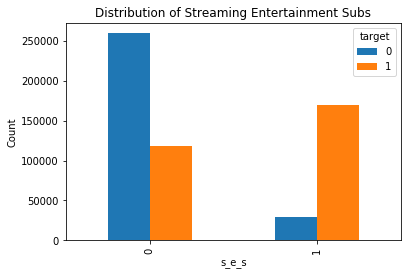

In [27]:
pd.crosstab(combined_train.streaming_entertainment_subs, combined_train.target).plot(kind='bar')
plt.title('Distribution of Streaming Entertainment Subs')
plt.xlabel('s_e_s')
plt.ylabel('Count')

This plot goes hand in hand with the one above, those who listen to streaming entertainment are more likely to listen to podcasts, and be a part of the demographic that listens to this particular podcast. 

Text(0, 0.5, 'Count')

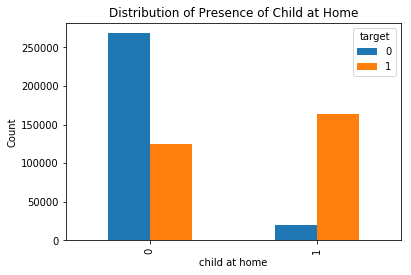

In [116]:
pd.crosstab(combined_train.presence_of_child_ind, combined_train.target).plot(kind='bar')
plt.title('Distribution of Presence of Child at Home')
plt.xlabel('child at home')
plt.ylabel('Count')

This plot also goes hand in hand with the one above, those with a child at home are more likely to stay at home and listen to podcasts. 

Text(0, 0.5, 'Count')

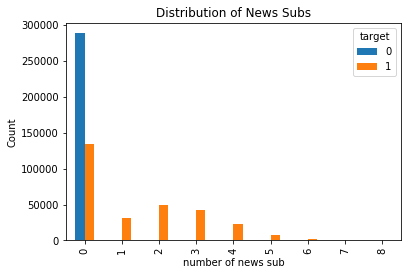

In [117]:
pd.crosstab(combined_train.number_of_news_subs, combined_train.target).plot(kind='bar')
plt.title('Distribution of News Subs')
plt.xlabel('number of news sub')
plt.ylabel('Count')

This plot shows us that those who are not subscribed to any news subs do not listen to the podcast at all, this could also be an important feature. 

### Training and Model Selection

#### Model Selection: Random Forest Classifier 

When trying to determine what model to select, the first thing that came to mind was a logistic classifier. This is a very common baseline model that can be used for binary classification. It is easy to implement, robust to noise and is an industry favorite. 

When dissecting the data a bit more, I came to realize there were a lot of categorical variables in our dataset. The Random Forest Classifier uses many different decision trees to capture more complex patterns within the features to provide better accuracy. It looks at many different random subsets of features to determine influential features. It can perform well with categorical data and seemed to be the appropriate choice for this problem. 

In [97]:
rf = RandomForestClassifier(n_estimators=100, bootstrap=True)

#reshape y_train to be 1D 
y_train = np.array(y_train).reshape((len(y_train), ))
#remove the person_id in x_train
new_x_train = x_train.drop(columns=['anon_person_id'])
rf.fit(new_x_train, y_train)

RandomForestClassifier()

In [101]:
new_x_test = x_test.drop(columns=['anon_person_id'])
predictions = rf.predict_proba(new_x_test)

#### Hypertuning - typically I would hypertune a model to find its best parameters

Due to the time constraints (each fold was taking extremely long time - it would take a day if I left it), I will not be implementing this step here, but I do want to say that I think this step is useful for determining the best parameters to train the random forest classifier with. This could provide us with a potentially even better accuracy.  

In [54]:
#hypertuning

n_estimators = [x for x in range(200, 2000, 10)]
max_depth = [x for x in range(100, 500, 10)]

grid = {'n_estimators': n_estimators, 'max_depth': max_depth}
rs_cv = RandomizedSearchCV(estimator = rf, param_distributions = grid, n_iter = 10, cv = 3, 
                           #verbose=2, random_state=4, n_jobs=-1)

rs_cv.fit(x_train, y_train)
print(rs_cv.best_params_)
                           
#pick the best parameters to retrain the classifier and predict 

#### Evaluation 

Because this is binary classification, one of the metrics I am using the evaluate my model is accuracy. This will provide us with information on how well our model, and use the test accuracy to potentially determine if the model had underfit/overfit. 

Another useful metric that will give us information on how well the model distinguishes between one class or the other is AUC. If the AUC is low, we know that the model is very poor and actually predicts positives as negatives and vice versa. If the AUC is around 0.5, our model has no sense of distinguishment between 1s and 0s. Our aim is to get our model to have an AUC close to 1, as this would let us know that our model has done a good job in identifying the true positives and true negatives. 

In [55]:
#after hypteruning, create a new classifier with the parameters and 
#refit the classifier to the training data 

#going with arbitrary parameters because I did not complete hypertuning 
rf = RandomForestClassifier(n_estimators=100, bootstrap=True)
rf.fit(x_train, y_train)

RandomForestClassifier()

In [56]:
#this function returns the probabilities for each class 
predictions = rf.predict_proba(x_test)

In [102]:
#separate our predictions list into the probability for the majority class and a list with
#majority class 

probabilities = []
preds = []

for i in range(len(predictions)):
    probs = predictions[i]
    if probs[0] > probs[1]:
        preds.append(0)
        probabilities.append(probs[0])
    else: 
        preds.append(1)
        probabilities.append(probs[1])

#### Accuracy

In [104]:
metrics.accuracy_score(y_test.to_list(), preds)

0.933506445330613

We got a test accuracy of 93.3%, this is a good sign that our model did not overfit.

#### AUC

In [105]:
fpr, tpr, thresholds = metrics.roc_curve(y_test.to_list(), predictions[: ,1], pos_label=1)
metrics.auc(fpr, tpr)

0.9822735988488105

Our test AUC is 0.98, which is really close to 1. This is a good sign as well that our model is able to distinguish true positives as positives and true negatives as negatives. Overall, our model has performed well with both accuracy and AUC. 

#### Feature Selection

In [112]:
feature_selection = SelectFromModel(RandomForestClassifier(n_estimators = 100))
feature_selection.fit(new_x_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [115]:
selected_features = new_x_train.columns[(feature_selection.get_support())]
print(selected_features)

Index(['presence_of_child_ind', 'streaming_media_subs',
       'streaming_entertainment_subs', 'number_of_news_subs', 'age'],
      dtype='object')


The best selected features are in line with our predictions, streaming media subs and streaming entertainment subs are considered important. 

##### Write to csv file

In [106]:
#create a dataframe to write to a csv 
scores_df = pd.DataFrame()
scores_df['anon_person_id'] = x_test['anon_person_id']
scores_df['target'] = y_test.to_list()
scores_df['prediction'] = preds 
scores_df['probability'] = probabilities

In [109]:
scores_df.to_csv('scores.csv', index=False,  sep='|')